In [1]:
from imprint.nb_util import setup_nb
setup_nb()

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imprint as ip
import imprint.bound.normal as normal
from imprint.models.ztest import ZTest1D

In [2]:
theta_min = -1
theta_max = 0
n_sims = 8192
alpha = 0.025
delta = 0.01
z_crit = scipy.stats.norm.isf(alpha)

In [3]:
grid = ip.cartesian_grid(
    theta_min=[theta_min],
    theta_max=[theta_max],
    n=[1],
    null_hypos=[ip.hypo("x <= 0")],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1675731569, n_bits=18, worker_bits=18) = [4474932129419231232, ...]:


In [4]:
rej_df = ip.validate(ZTest1D, grid, -z_crit, K=n_sims)

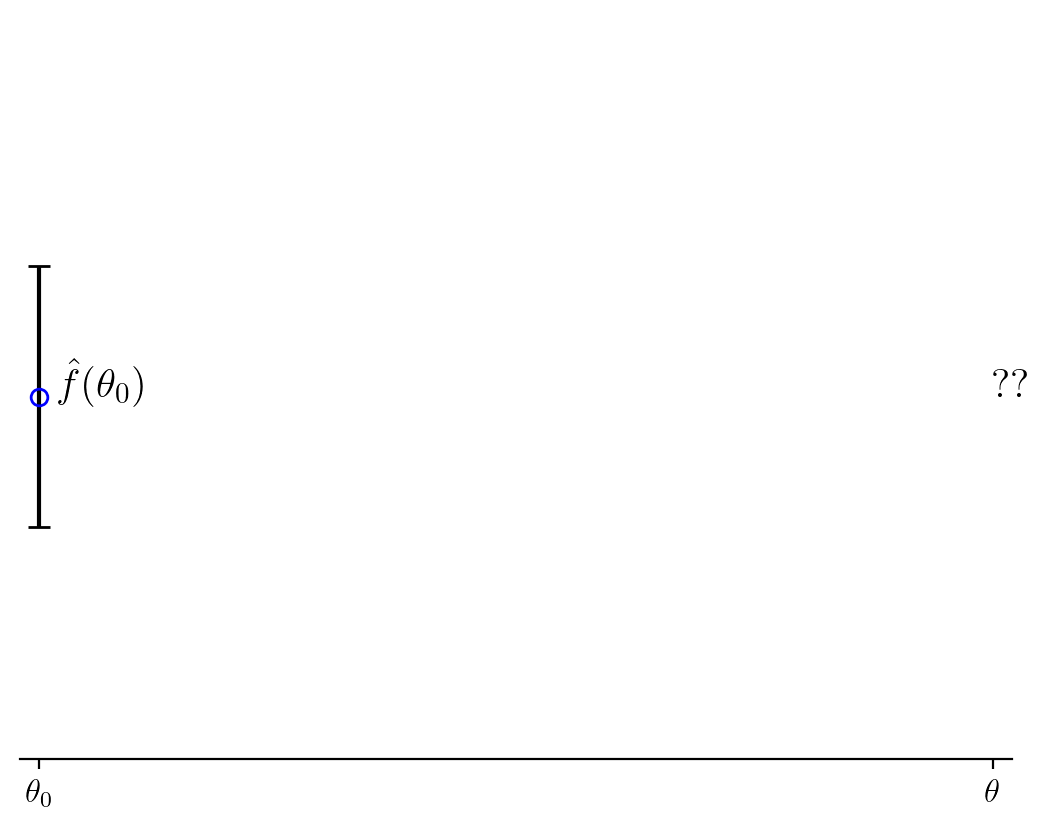

In [5]:
fig = plt.figure()
theta, theta0, tie0, cp0 = (
    theta_max,
    grid.get_theta()[0,0], 
    rej_df['tie_est'][0], 
    rej_df['tie_cp_bound'][0]
)
ax = plt.subplot(1,1,1)
ax.errorbar(
    theta0, tie0,
    yerr=cp0-tie0,
    ecolor='black',
    capsize=4,
    fmt='o',
    markeredgecolor="b",
    markerfacecolor="none",
)
ax.annotate(f'$\hat{{f}}(\\theta_{0})$', (theta0 + 1e-2, tie0))
ax.annotate(f'$??$', (theta, tie0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xticks([theta0, theta], labels=['$\\theta_0$', '$\\theta$'])
ax.set_xlim(left=theta0-0.01, right=theta+0.01)
ax.set_ylim(bottom=0, top=cp0 * 1.5)
plt.savefig('figures/validation_problem.pdf', bbox_inches='tight')
plt.show()

In [102]:
vs = jnp.linspace(0, theta-theta0, 1000, endpoint=True)
fwd_solver = normal.ForwardQCPSolver(1)
qs = jax.vmap(fwd_solver.solve, in_axes=(0, None))(vs, cp0)
bounds = jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None))(
    qs, 1, vs, cp0,
)

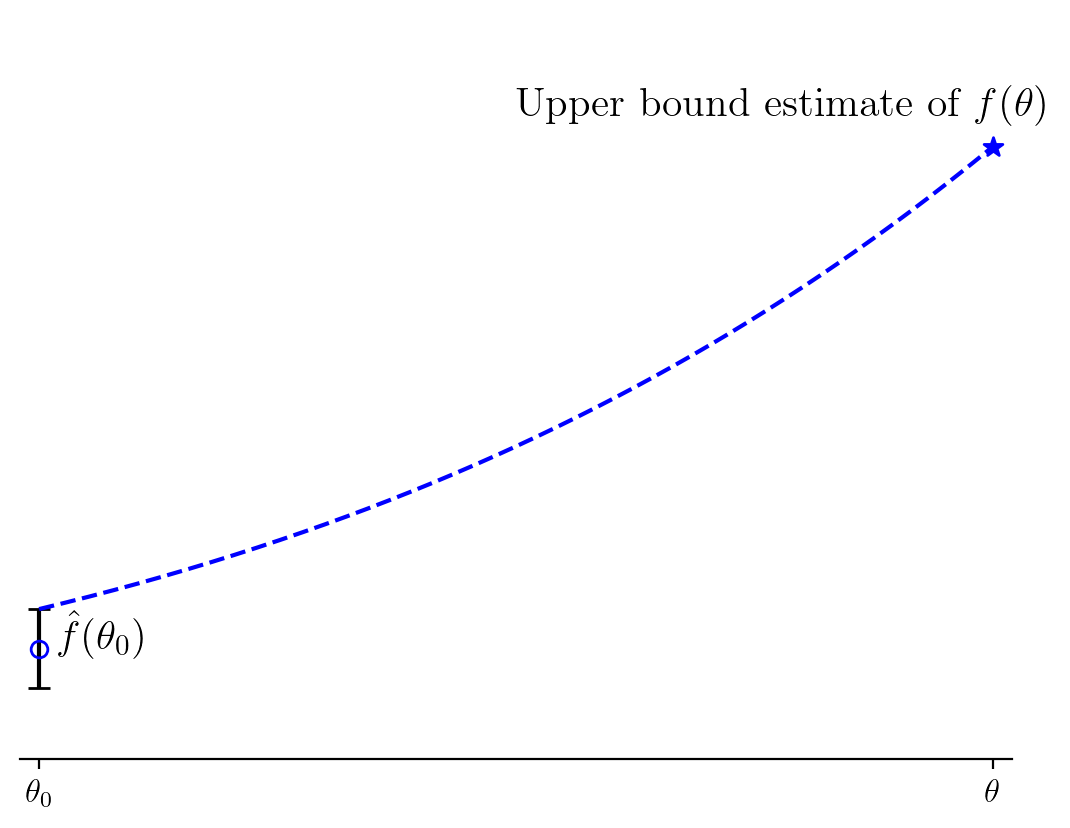

In [116]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.errorbar(
    theta0, tie0,
    yerr=cp0-tie0,
    ecolor='black',
    capsize=4,
    fmt='o',
    markeredgecolor="b",
    markerfacecolor="none",
)
ax.annotate(f'$\hat{{f}}(\\theta_{0})$', (theta0 + 1e-2, tie0))

ax.plot(theta0 + vs, bounds, linestyle='--', color='b')
ax.scatter(theta, bounds[-1], s=50, marker='*', color='b')
ax.annotate(f'Upper bound estimate of $f(\\theta)$', (theta-2.5e-1, bounds[-1] * 1.05))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.set_xticks([theta0, theta_max], labels=['$\\theta_0$', '$\\theta$'])
ax.set_xlim(left=theta0-0.01, right=theta_max+0.01)
ax.set_ylim(bottom=0, top=alpha * 1.8)
plt.savefig('figures/validation_solution.pdf', bbox_inches='tight')
plt.show()

In [147]:
def tie(theta, thresh):
    return scipy.stats.norm.sf(thresh-theta)

def validate(
    n, 
    theta_min=theta_min, 
    theta_max=theta_max,
    z_crit=z_crit,
    n_sims=n_sims,
    plt_grid_size=1000,
    v_size=1000,
):
    # create grid
    grid = ip.cartesian_grid(
        theta_min=[theta_min],
        theta_max=[theta_max],
        n=[n],
        null_hypos=[ip.hypo("x <= 0")],
    )
    thetas = grid.get_theta()[:, 0]
    radius = grid.get_radii()[0, 0]

    # run test
    rej_df = ip.validate(ZTest1D, grid, -z_crit, K=n_sims)

    # set up plotting variables
    vlist = np.linspace(0, radius, v_size)
    x = np.linspace(theta_min, theta_max, plt_grid_size)
    true_ties = tie(x, z_crit)
    tie_est = rej_df['tie_est']
    tie_err = rej_df['tie_cp_bound'] - tie_est
    qsolve = normal.ForwardQCPSolver(scale=1)

    fig = plt.figure()
    ax = plt.subplot(1,1,1)
    ax.plot(x, true_ties * 100, "r:", linewidth=2, label='True TIE')
    
    capsize = 4 if n <= 32 else 2
    elinewidth = None if n <= 32 else 0.5
    fmt = 'o' if n <= 32 else '.'
    ax.errorbar(
        thetas,
        tie_est * 100,
        yerr=tie_err * 100,
        ecolor="k",
        fmt=fmt,
        capsize=capsize,
        markeredgecolor="k",
        markerfacecolor="none",
        elinewidth=elinewidth,
    )

    # Plot bounds
    for i in range(n):
        ystart = tie_est[i] + tie_err[i]

        # Plot centered bounds
        vadjust = np.concatenate([np.flip(-vlist), vlist])
        optqs = jax.vmap(qsolve.solve, in_axes=(0, None))(vadjust, ystart)
        optbound = jax.vmap(normal.tilt_bound_fwd_tile, in_axes=(0, None, 0, None))(optqs, 1, vadjust, ystart)
        vadjust += thetas[i]
        label = 'Optimized Tilt-Bound' if i == 0 else None
        ax.plot(vadjust, optbound * 100, "b", linewidth=1, label=label)

    ax.set_xlabel("$\\theta$")
    ax.set_ylabel("Type I Error (\%)")
    ax.set_ylim(bottom=0, top=alpha * 1.2 * 100)
    plt.legend()
    plt.savefig(f"figures/validation_{n}.pdf", bbox_inches="tight")
    plt.show()

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1675409786, n_bits=18, worker_bits=18) = [4452819370036690944, ...]:


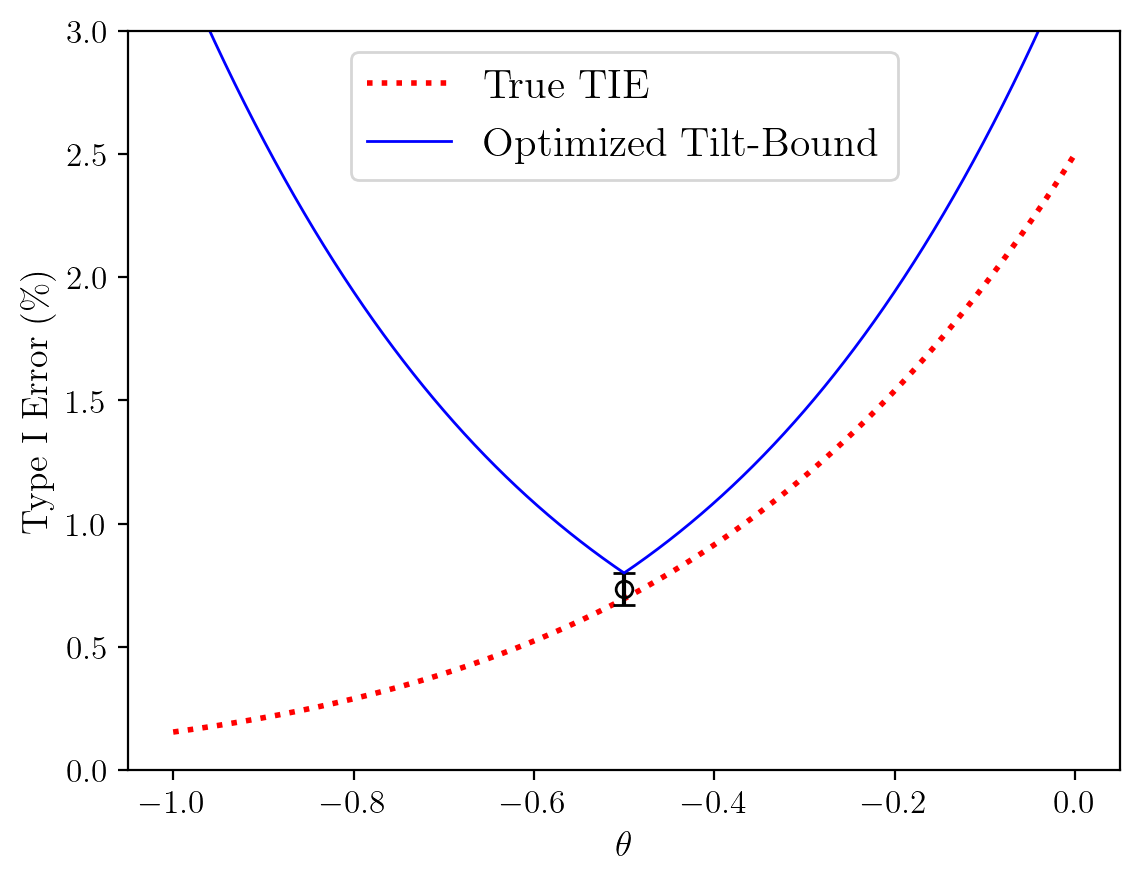

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=2, worker_id=1, t=1675409787, n_bits=18, worker_bits=18) = [4452819438756167680 4452819438756167681, ...]:


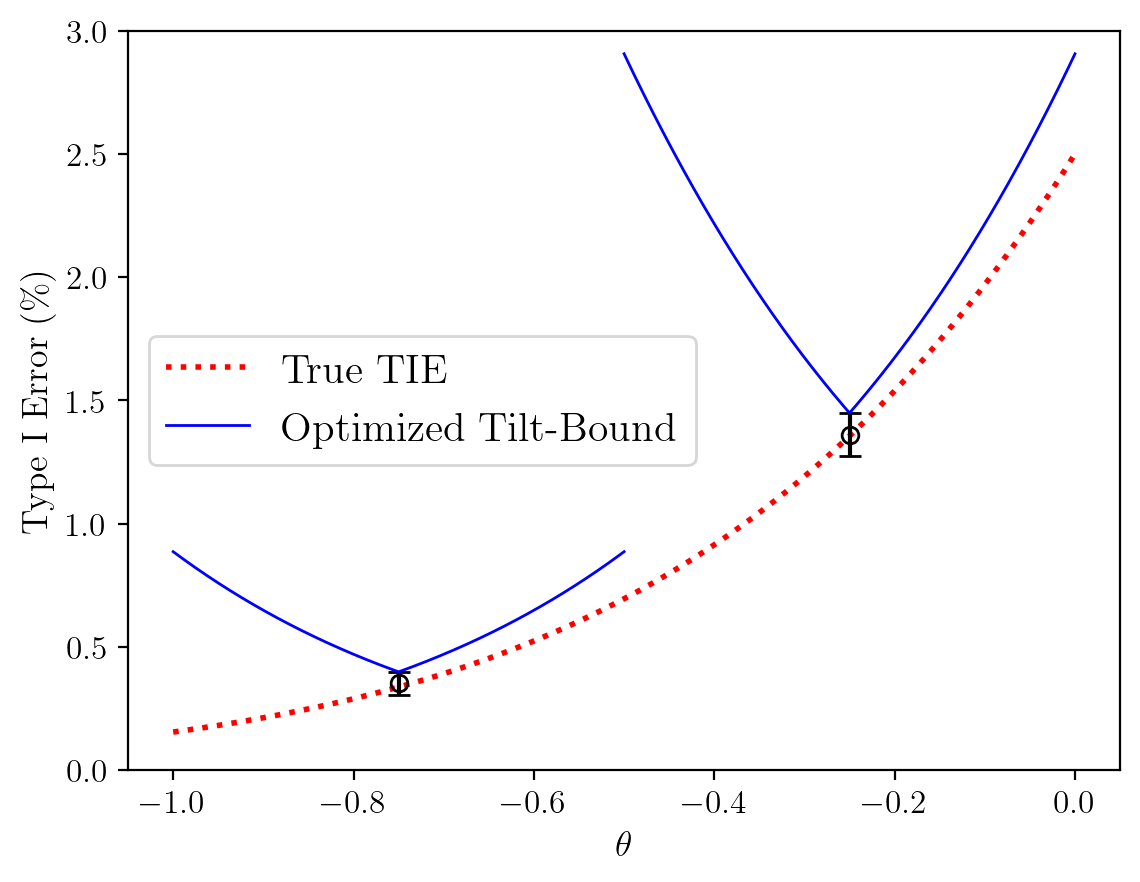

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=4, worker_id=1, t=1675409788, n_bits=18, worker_bits=18) = [4452819507475644416 4452819507475644417 4452819507475644418, ...]:


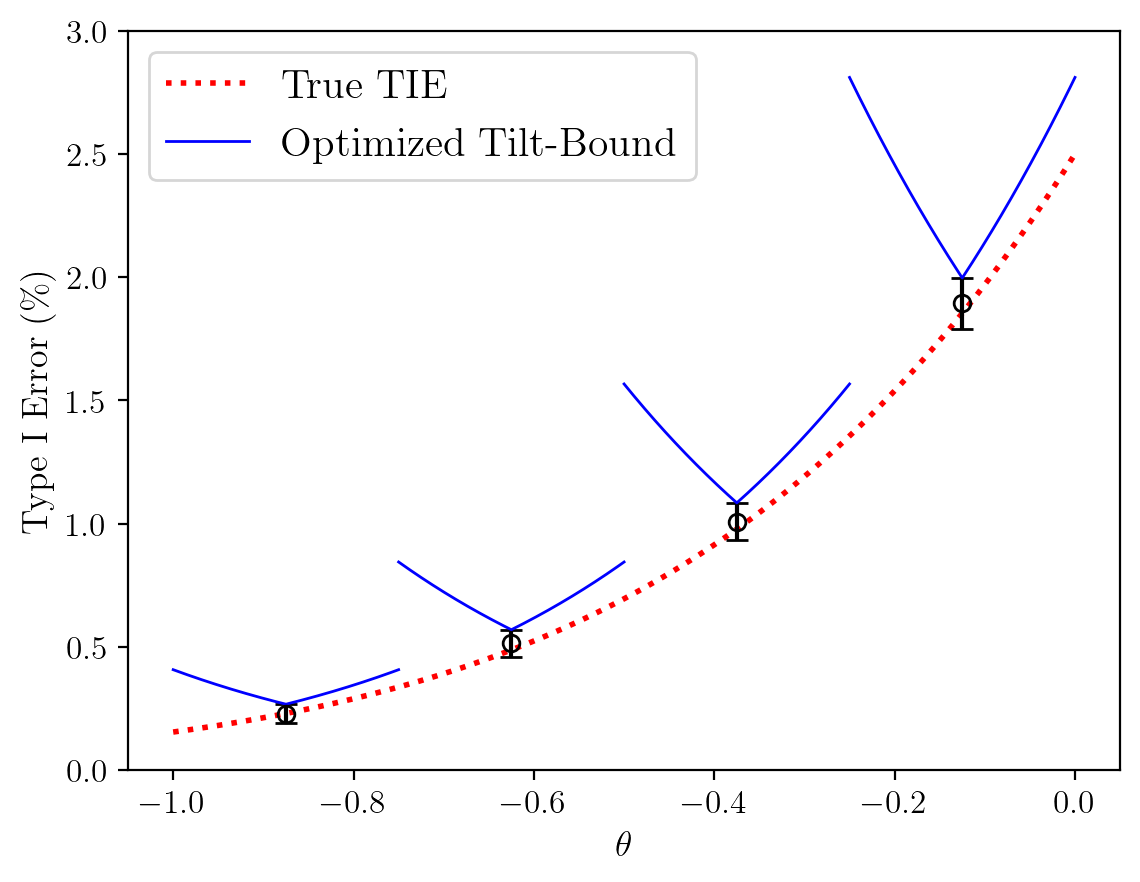

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=8, worker_id=1, t=1675409789, n_bits=18, worker_bits=18) = [4452819576195121152 4452819576195121153 4452819576195121154, ...]:


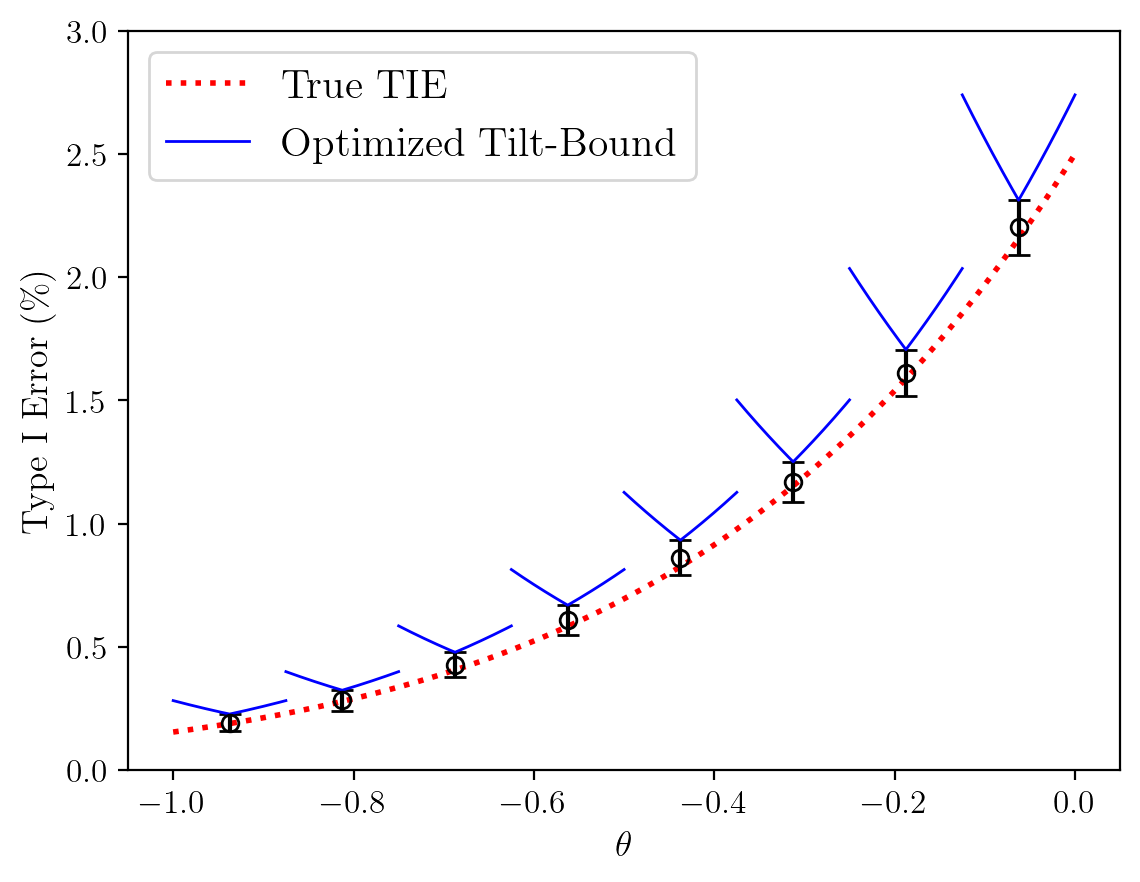

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=16, worker_id=1, t=1675409790, n_bits=18, worker_bits=18) = [4452819644914597888 4452819644914597889 4452819644914597890, ...]:


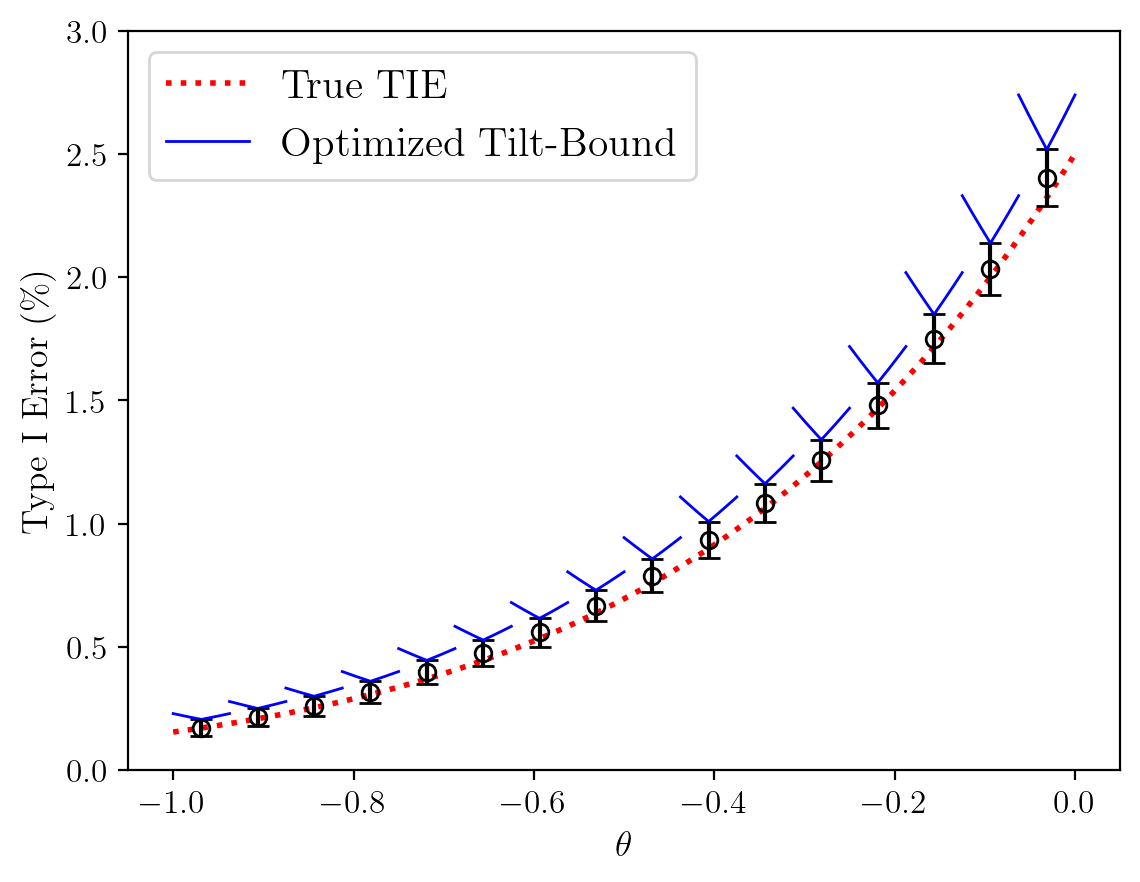

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=32, worker_id=1, t=1675409791, n_bits=18, worker_bits=18) = [4452819713634074624 4452819713634074625 4452819713634074626, ...]:


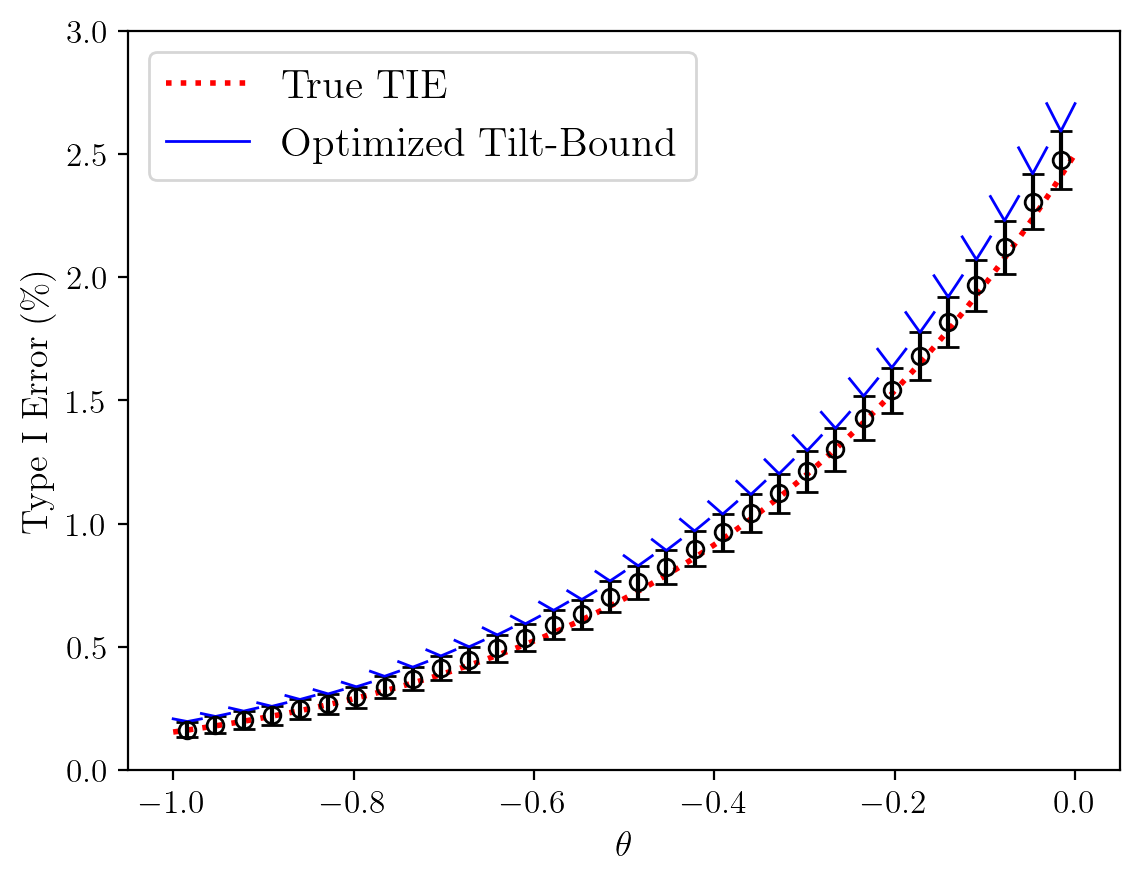

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=64, worker_id=1, t=1675409792, n_bits=18, worker_bits=18) = [4452819782353551360 4452819782353551361 4452819782353551362, ...]:


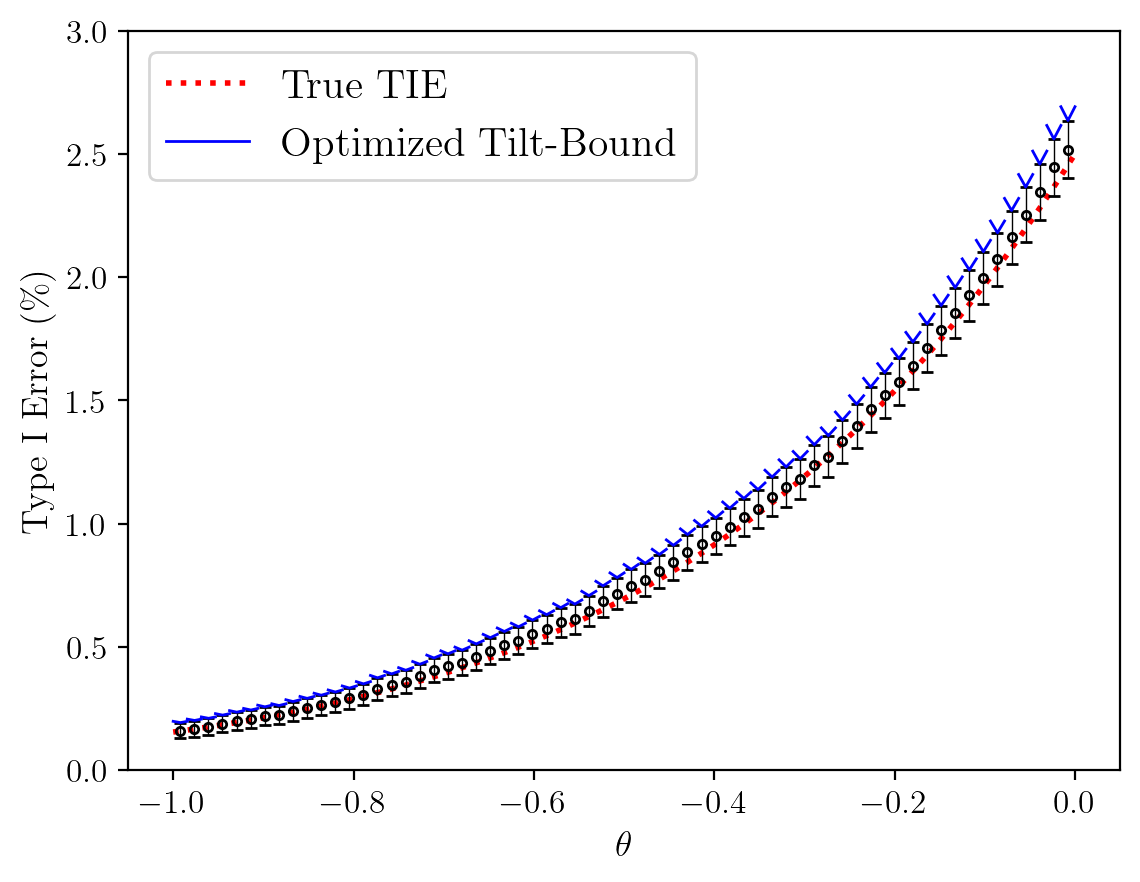

In [148]:
for n in [1, 2, 4, 8, 16, 32, 64]:
    validate(n, n_sims=100000)